In [1]:
import os
current_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
os.chdir(current_dir)

import numpy as np
import matplotlib.pyplot as plt
from commons.simulation import *

# Data 받아오기

흥미로운 파일명들
1. 0.0612.csv: 가장 긴 연산시간, 예측 결과도 이상함
2. 0.062.csv: 가장 MSE가 높음, 작은 나선을 직선으로 예측
3. 0.018.csv: 가장 MSE가 낮음

0.0918.csv 잘 맞지 않는 case의 예시

In [2]:
import pandas as pd
import os

def get_files_in_dir(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

filename = np.random.choice(np.array(get_files_in_dir('data/Topas - single cell/raw/LOR')))
print(filename)

LORs_dir = 'data/Topas - single cell/raw/LOR/' + filename
ground_truths_dir = 'data/Topas - single cell/raw/GT/' + filename
    

LORs = pd.read_csv(LORs_dir).values
ground_truths = pd.read_csv(ground_truths_dir).values

0.0019.csv


## visualize

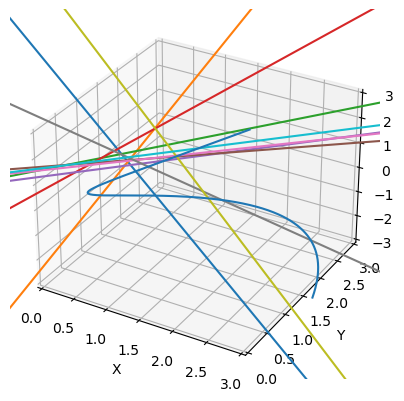

In [3]:
from mpl_toolkits.mplot3d import Axes3D

t, x, y, z = ground_truths.T

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

for i in LORs[200:210]:
    ax.plot([i[0], i[4]], [i[1], i[5]], [i[2], i[6]])
ax.plot(x, y, z)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([0, 3])
ax.set_ylim([0, 3])
ax.set_zlim([-3, 3])

plt.show()

# Data 분석

In [4]:
k = 3

knot_space = 7500
A = LORs.T


# P & v
P1 = A[0:3, :]
P2 = A[4:7, :]
times = A[3, :]

tc1, tc2 = 0, 150000

v = P2 - P1
norms = np.linalg.norm(v, axis=0)
v = v / norms


# knots
N = int(np.round((tc2 - tc1) / knot_space)) + 1 # basis function 수
T = np.linspace(tc1, tc2, np.maximum(2, N + 1 - k))   
knots = np.r_[[0]*k, T, [T[-1]]*k]   


# initialize
a0 = np.zeros((3, N)) 

## 최적화

In [5]:
import timeit

In [6]:
lambda0 = 0.005
dmax = 4

### Backpropagation

In [7]:
from commons.optimizers import single_cellGPS

In [8]:
start_time = timeit.default_timer()

a = np.zeros((3, N))

a = single_cellGPS(a, LORs, N, k, knots, lambda0, dmax, options={'maxiter': 2000, 'disp': True})

print(f"\n코드 실행 시간: {timeit.default_timer() - start_time}초")

Optimization terminated successfully.
         Current function value: 1.032689
         Iterations: 128
         Function evaluations: 130
         Gradient evaluations: 130

코드 실행 시간: 0.06130150007084012초


### Numerical Gradient

In [9]:
from scipy.optimize import minimize
from commons.loss import objf3D

In [10]:
start_time = timeit.default_timer()


b = a0.copy()
options = {'maxiter': 2000, 'disp': True}
result = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax, lambda0), b, method='BFGS', options=options)
b = result.x


print(f"\n코드 실행 시간: {timeit.default_timer() - start_time}초")

C:\Users\Programming\AppData\Local\Temp\ipykernel_16444\2151145874.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax, lambda0), b, method='BFGS', options=options)


Optimization terminated successfully.
         Current function value: 1.032996
         Iterations: 127
         Function evaluations: 8256
         Gradient evaluations: 129

코드 실행 시간: 2.3409343999810517초


# Plotting

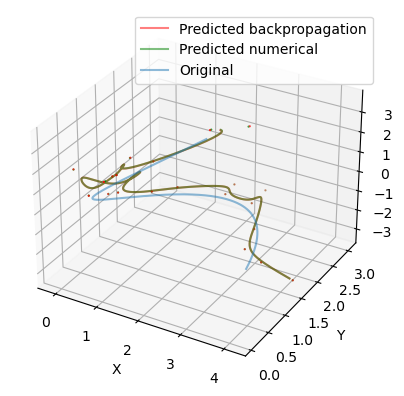

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline


# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot the spline
for i in range(2):
    X = [a, b][i]
    color = ['red', 'green'][i]
    name = ['backpropagation', 'numerical'][i]
    
    # Control points
    X = X.reshape((3, -1))
    s_x = X[0,]
    s_y = X[1,]
    s_z = X[2,]

    # Plot the control points
    ax.scatter(s_x, s_y, s_z, color=color, s=0.3)

    # Predict times
    tm1, tm2 = round(times[0])-1, round(times[-1])+1
    Nr = 500
    te = np.linspace(tm1, tm2, Nr)

    # Create B-spline and Predictions
    spl_x = BSpline(knots, s_x, k)
    spl_y = BSpline(knots, s_y, k)
    spl_z = BSpline(knots, s_z, k)
    x_predict = spl_x(te)
    y_predict = spl_y(te)
    z_predict = spl_z(te)
    
    ax.plot(x_predict, y_predict, z_predict, color=color, label=f'Predicted {name}', alpha=0.5)

    
    
ax.plot(x, y, z, label='Original', alpha=0.5)
# Display the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()